In [1]:
# libraries 
import numpy as np
import numpy.matlib
import cvxpy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import time
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import stats
import torch
import sklearn.linear_model
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import scipy.io as sio
import torch.nn.functional as F
from sklearn import svm
from sklearn.datasets import make_blobs

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [2]:
from data_utils import get_CIFAR10_data
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")


X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [34]:
def generate_u_vectors_manual(prev_dim, P, verbose=False): 
    
    d = prev_dim
    u_vector_list = []      # random vectors used to generate the sign patterns

    for i in range(P): 
        # Obtain a sign pattern
        # Future work: use a different sampling distribution than Gaussian
        
        # First, sample u from normal distribution
        u = np.random.normal(0, 1, (d,1)) 
        
        u_vector_list.append(u)
    if verbose:
        print("Number of sign patterns generated: " + str(len(u_vector_list)))
    return u_vector_list

def one_hot(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels.long()] 

class PrepareData(Dataset):
    #  converts data from numpy array to torch tensor
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [35]:
class custom_cvx_layer(torch.nn.Module):
    def __init__(self, n, d, num_neurons, u_vector_list, multiclass = False, out_layer = True):
        """
        Variables:
        w, v: matrices, arguments to the argmin of (8) in paper
        u_vectors_as_np: numpy array of vectors used to generate diagonals
        h: torch tensor of u_vectors_as_np
        """
        super(custom_cvx_layer, self).__init__()
        self.multiclass = multiclass
        self.out_layer = out_layer
        
        u_vectors_as_np = np.asarray(u_vector_list).reshape((num_neurons, d)).T
        self.h = torch.nn.Parameter(data=torch.Tensor(u_vectors_as_np), requires_grad=False)  # (D, P)
        
        if self.multiclass:
            self.v = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)  # (P, D, C)
            self.w = torch.nn.Parameter(data=torch.zeros(num_neurons, d, num_classes), requires_grad=True)
            self.h.unsqueeze(2)  # (D, P, 1)
        else:
            self.w = torch.nn.Parameter(data=torch.zeros(d, num_neurons), requires_grad=True)  # (D, P)
            self.v = torch.nn.Parameter(data=torch.zeros(d, num_neurons), requires_grad=True)
        
    def forward(self, x):
        """
        Generates sign patterns on the fly, then carries out the prediction
        inside of (8)
        """
        if self.multiclass:
            x = x.view(x.shape[0], -1)
        
        sign_patterns = (torch.matmul(x, self.h) >= 0)
        
        Xv_w = torch.matmul(x, self.v - self.w)  # (N, P) if binary, (N, P), if multiclass (P, N, C)
        
        if self.multiclass:
            Xv_w = Xv_w.permute(1, 0, 2)  # (N, P, C)
            
        DXv_w = torch.mul(sign_patterns, Xv_w)
        
        out = DXv_w  # (N, P) if binary, (N, P, C) if multiclass
        
        if self.out_layer:
            out = torch.sum(DXv_w, dim=1, keepdim = False if self.multiclass else True)  # (N, 1) binary, (N, C) multiclass
        
        return out

class custom_cvx_layer_multilayer(torch.nn.Module):
    def __init__(self, n, d, num_neurons_list, u_vector_array, num_layers=1, batchmomentum=0.1, multiclass = False):
        super(custom_cvx_layer_multilayer, self).__init__()
        
        assert len(num_neurons_list) == num_layers
        assert len(u_vector_array) == num_layers
        
        self.multiclass = multiclass
        self.num_layers = num_layers
        self.out_layer = 0
        self.layers = []
        self.batchnorm_layers = []
        
        for i in range(num_layers):
            if i == 0:
                prev_dimension = d
            else:
                prev_dimension = num_neurons_list[i - 1]
            u_vectors_as_np = np.float32(np.asarray(u_vector_array[i]).reshape((num_neurons_list[i], prev_dimension)).T)
            self.layers.append(custom_cvx_layer(n, prev_dimension, num_neurons_list[i], u_vectors_as_np, multiclass, out_layer = True))           
            self.batchnorm_layers.append(torch.nn.BatchNorm1d(prev_dimension, eps=1e-5, momentum=batchmomentum, affine=False))  # TODO: freeze?

    def set_out_layer(self, layer):
        self.out_layer = layer
        for i in range(self.num_layers):
            if i != layer:
                self.layers[i].out_layer = False
                self.layers[i].requires_grad = False
                self.batchnorm_layers[i].requires_grad = False
            if i == layer:
                self.layers[i].out_layer = True
                self.layers[i].requires_grad = True
                self.batchnorm_layers[i].requires_grad = True
                
    def current_vwh(self):
        v = self.layers[self.out_layer].v
        w = self.layers[self.out_layer].w
        h = self.layers[self.out_layer].h
        return v, w, h
    

    def forward(self, x):
        for i in range(self.out_layer + 1):
            x = self.batchnorm_layers[i](x)
            x = self.layers[i](x)
        return x

def loss_func_cvxproblem_binary(yhat, y, model, _x, beta, rho):
    """
    This implements the conex problem described by equation (8)
    """
    # term 1, the square-distance loss
    loss = 0.5 * torch.norm(yhat - y)**2/y.shape[0]
    
    # term 2, the regularization term
    m1=torch.mean(torch.norm(model.v, dim=0))
    m2=torch.mean(torch.norm(model.w, dim=0))
    norms1=torch.norm(model.v, dim=0)#*(torch.norm(model.v, dim=0)>=m1)
    norms2=torch.norm(model.w, dim=0)#*(torch.norm(model.w, dim=0)>=m2)
    loss = loss + beta * torch.sum(norms1)
    loss = loss + beta * torch.sum(norms2)
    
    # term 3, enforces the inequality constraints
    if rho>0:
        sign_patterns = (torch.matmul(_x, model.h) >= 0)

        Xv = torch.matmul(_x, model.v)
        DXv = torch.mul(sign_patterns, Xv)
        relu_term_v = torch.max(-2*DXv + Xv, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_v)

        Xw = torch.matmul(_x, model.w)
        DXw = torch.mul(sign_patterns, Xw)
        relu_term_w = torch.max(-2*DXw + Xw, torch.Tensor([0]))
        loss = loss + rho * torch.sum(relu_term_w)
    
    return loss

def validation_cvxproblem_binary(model, testloader, beta, rho):
    test_loss = 0
    test_correct = 0
    test_noncvx_cost = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float()
        _y = Variable(_y).float()

        yhat = model(_x).float()

        loss = loss_func_cvxproblem(yhat, _y, model, _x, beta, rho)
        test_loss += loss.item()
        test_correct += torch.eq(torch.sign(yhat), _y).float().sum()
        
        test_noncvx_cost += get_nonconvex_cost(_y, model, _x, beta)

    return test_loss, test_correct, test_noncvx_cost

    
def loss_func_cvxproblem_multiclass(yhat, y, model, _x, sign_patterns, beta, rho, device):
    _x = _x.view(_x.shape[0], -1)
    
    # term 1
    loss = 0.5 * torch.norm(yhat - y)**2
    # term 2
    loss = loss + beta * torch.sum(torch.norm(model.v, dim=1))
    loss = loss + beta * torch.sum(torch.norm(model.w, dim=1))
    
    # term 3
    sign_patterns = sign_patterns.unsqueeze(2) # N x P x 1
    
    Xv = torch.matmul(_x, torch.sum(model.v, dim=2, keepdim=True)) # N x d times P x d x 1 -> P x N x 1
    DXv = torch.mul(sign_patterns, Xv.permute(1, 0, 2)) # P x N x 1
    relu_term_v = torch.max(-2*DXv + Xv.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_v)
    
    Xw = torch.matmul(_x, torch.sum(model.w, dim=2, keepdim=True))
    DXw = torch.mul(sign_patterns, Xw.permute(1, 0, 2))
    relu_term_w = torch.max(-2*DXw + Xw.permute(1, 0, 2), torch.Tensor([0]).to(device))
    loss = loss + rho * torch.sum(relu_term_w)
    
    return loss

def validation_cvxproblem_multiclass(model, testloader, beta, rho):
    test_loss = 0
    test_correct = 0

    for ix, (_x, _y) in enumerate(testloader):
        _x = Variable(_x).float()
        _y = Variable(_y).float()

        yhat = model(_x).float()

        loss = loss_func_cvxproblem_multiclass(yhat, _y, model, _x, beta, rho)
        test_loss += loss.item()
        test_correct += torch.eq(torch.sign(yhat), _y).float().sum()

    return test_loss, test_correct
    
def sgd_solver_cvxproblem_multilayer(A_train, y_train, A_test, y_test, num_epochs, num_neurons_list, beta, 
                       learning_rate, batch_size, rho, u_vector_array, multiclass = False, verbose=False):
    
    device = torch.device('cpu')

    n, d = A_train.shape
    
    # create the model
    num_layers = len(num_neurons_list)
    model = custom_cvx_layer_multilayer(n, d, num_neurons_list, u_vector_array, num_layers, multiclass).to(device)
    
    # arrays for saving the accuracy
    losses = np.zeros((num_layers, int(num_epochs*np.ceil(A_train.shape[0] / batch_size)))) 
    accs = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_layers, num_epochs+1))
    accs_test = np.zeros((num_layers, num_epochs+1))

    
    times = np.zeros((losses.shape[1] * num_layers + 1))
    times[0] = time.time()
    
    # dataset loaders (minibatch)
    ds = PrepareData(X=A_train, y=y_train)
    ds = DataLoader(ds, batch_size=batch_size, shuffle=True)
    ds_test = PrepareData(X=A_test, y=y_test)
    ds_test = DataLoader(ds_test, batch_size=A_test.shape[0], shuffle=False) # note batch_size
    
    time_iter = 0
    for L in range(num_layers):
        print("Training layer ", L, " with learning rate ", learning_rate[L])
        model.set_out_layer(L)
        losses_test[L][0], accs_test[L][0] = validation_cvxproblem_multilayer(model, ds_test, beta, rho) # loss on the entire test set
        iter_no = 0
        # new optimizer to reset momentum so that it doesn't update frozen layers
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate[L])
    
        for i in range(num_epochs):
            for ix, (_x, _y) in enumerate(ds):
                #=========make input differentiable=======================
                _x = Variable(_x).float()
                _y = Variable(_y).float()

                #========forward pass=====================================
                yhat = model(_x).float()
                
                loss = loss_func_cvxproblem_multilayer(yhat, _y, model, _x, beta, rho)
                correct = torch.eq(torch.sign(yhat), _y).float().sum() # accuracy

                #=======backward pass=====================================
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss

                losses[L][iter_no] = loss.item() # loss on the minibatch
                accs[L][iter_no] = correct

                iter_no += 1
                time_iter += 1
                times[time_iter] = time.time()

            # get test loss and accuracy
            losses_test[L][i+1], accs_test[L][i+1] = validation_cvxproblem_multilayer(model, ds_test, beta, rho) # accuracy on the entire test set

            if i % 1 == 0:
                print("Epoch [{}/{}], TRAIN: cvx loss: {} acc: {}. TEST: cvx loss: {} acc: {}".format(i, num_epochs,
                    np.round(losses[L][iter_no-1], 3), np.round(accs[L][iter_no-1]/batch_size, 3), 
                    np.round(losses_test[L][i+1], 3), np.round(accs_test[L][i+1]/A_test.shape[0], 3)))
            
    return accs/batch_size, accs_test/A_test.shape[0], times, model, losses, losses_test

In [36]:
# cifar-10 -- using the version downloaded from "http://www.cs.toronto.edu/~kriz/cifar.html"
# A=sio.loadmat('CIFAR10_multiclass.mat')['A']
# A_test=sio.loadmat('CIFAR10_multiclass.mat')['Atest']
# y=sio.loadmat('CIFAR10_multiclass.mat')['y1']
# y_test=sio.loadmat('CIFAR10_multiclass.mat')['ytest1']

A = data['X_train']
A = A.reshape((A.shape[0], -1))
A_test = data['X_val']
A_test = A_test.reshape((A_test.shape[0], -1))
y = data['y_train']  # changed y to y_ints
y_test = data['y_val']  # changed y_test to y_test_ints

# """ Our changes """
# y = np.zeros((y_ints.shape[0], 10))
# y[np.arange(y.shape[0]), y_ints] = 1
# y_test = np.zeros((y_test_ints.size, 10))
# y_test[np.arange(y_test_ints.size), y_test_ints] = 1

meanA=np.mean(A,axis=0)
A=A-meanA
A_test=A_test-meanA


# to get the first two classes only (for binary classification)
inds = np.argwhere(y <= 1)[:,0] # get the classes 0 and 1
A = A[inds, :]
y = y[inds].reshape((inds.shape[0], 1))
y=2*y.astype(float)-1
inds_test = np.argwhere(y_test <= 1)[:,0] # get the classes 0 and 1
A_test = A_test[inds_test, :]
y_test = y_test[inds_test].reshape((inds_test.shape[0], 1))
y_test=2*y_test.astype(float)-1



n, d = A.shape
print(A.shape, y.shape, A_test.shape, y_test.shape)


(9794, 3072) (9794, 1) (206, 3072) (206, 1)


In [37]:
# SGD solver for the nonconvex problem
# generate random sign patterns
P, verbose = 500, True # P is number of sign patterns to generate *and* number of neurons
num_epochs, batch_size = 10, 200
beta = 1e-3
rho = 1e-5
learning_rates = [1e-7, 1e-7] # one per layer
multiclass = True

num_neurons_list = [P, P]
u_vector_list = generate_u_vectors_manual(A.shape[1], P, verbose)
u_vector_list_2 = generate_u_vectors_manual(P, P, verbose)
u_vector_array = [u_vector_list, u_vector_list_2]

results_cvx = sgd_solver_cvxproblem_multilayer(A, y, A_test, y_test, num_epochs, num_neurons_list, beta, 
                       learning_rates, batch_size, rho, u_vector_array, multiclass, verbose=False)

Number of sign patterns generated: 500
Number of sign patterns generated: 500
Training layer  0  with learning rate  1e-07


AttributeError: 'custom_cvx_layer_multilayer' object has no attribute 'v'

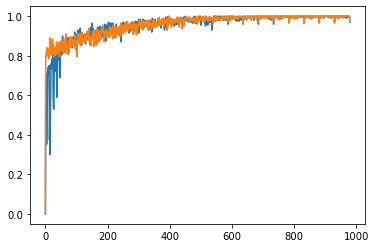

In [16]:
train_accs = results_cvx[0]
for i in range(train_accs.shape[0]):
    plt.plot(train_accs[i])
plt.show()

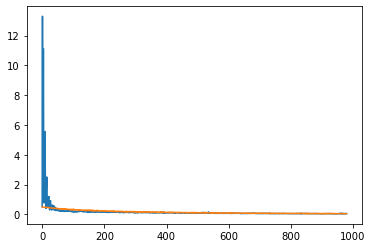

In [17]:
plt.clf()
train_losses = results_cvx[4]
for i in range(train_losses.shape[0]):
    plt.plot(train_losses[i])
plt.show()

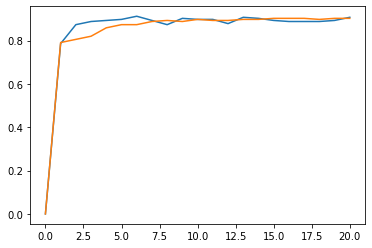

In [18]:
plt.clf()
test_accs = results_cvx[1]
for i in range(test_accs.shape[0]):
    plt.plot(test_accs[i])
plt.show()

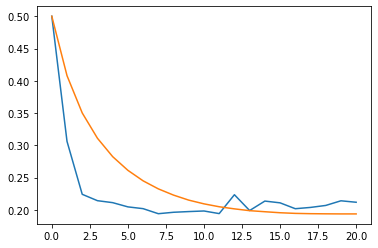

In [19]:
plt.clf()
test_losses = results_cvx[5]
for i in range(test_losses.shape[0]):
    plt.plot(test_losses[i])
plt.show()